## **AI Content Firewall for Kids - Kids.ai**

### `Business Understanding`

### `Data Understanding`

In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import plotly.express as px
import imghdr
import csv

from matplotlib import pyplot as plt
import tensorflow as tf

print(tf.__version__)

C:\Users\rache\AppData\Local\Temp\ipykernel_32456\619468304.py:6: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


2.18.0


#### **Load data set**

In [5]:
csv_file = "../Dataset/frame_data.csv"  
video_image_df = pd.read_csv(csv_file)
video_image_df.head()

,Subset,Label,Video Name,Frame Number,Timestamp (s),Image Path
0,train,Adult Content,10h30.tong106thaithinh_7224744031518035205,0,0.0,extracted_frames\train\Adult Content\10h30.ton...
1,train,Adult Content,10h30.tong106thaithinh_7224744031518035205,360,12.0,extracted_frames\train\Adult Content\10h30.ton...
2,train,Adult Content,1991.music.dj_7053983190456765722,0,0.0,extracted_frames\train\Adult Content\1991.musi...
3,train,Adult Content,199namm_7254949499859225861,0,0.0,extracted_frames\train\Adult Content\199namm_7...
4,train,Adult Content,1life.anthonyblane_7283159583516790021,0,0.0,extracted_frames\train\Adult Content\1life.ant...


In [6]:
video_image_df.shape

(14499, 6)

In [7]:
video_image_df['Label'] = video_image_df['Label'].replace({
    'Adult Content': 'Adult',
    'Harmful Content': 'Harmful'
})

In [8]:
# Count the occurrences of each label per subset
subset_counts = video_image_df.groupby(["Label", "Subset"]).size().reset_index(name="Count")

# Pivot the data to get a stacked format
pivot_df = subset_counts.pivot(index="Label", columns="Subset", values="Count").fillna(0)

# Plot the stacked bar chart using Plotly
fig = px.bar(pivot_df, 
             x=pivot_df.index, 
             y=["train", "test", "val"], 
             title="Class Distribution Across Train, Val, and Test",
             labels={"value": "Number of Transcriptions", "Label": "Category"},
             color_discrete_map={"train": "green", "test": "orange", "val": "yellow"},
             barmode="stack")

# Show the plot
fig.show()

In [9]:
video_image_df.drop(columns=['Subset', 'Video Name', 'Frame Number', 'Timestamp (s)'], inplace = True)
video_image_df.head()

,Label,Image Path
0,Adult,extracted_frames\train\Adult Content\10h30.ton...
1,Adult,extracted_frames\train\Adult Content\10h30.ton...
2,Adult,extracted_frames\train\Adult Content\1991.musi...
3,Adult,extracted_frames\train\Adult Content\199namm_7...
4,Adult,extracted_frames\train\Adult Content\1life.ant...


In [10]:
video_image_df['Label'].unique()

array(['Adult', 'Harmful', 'Safe', 'Suicide'], dtype=object)

In [11]:
video_image_df['Label'].value_counts()

Label
Safe       5896
Adult      3436
Harmful    3396
Suicide    1771
Name: count, dtype: int64

#### **Load Additional images from the web**

In [12]:
# Path to your top-level folder with subfolders "adult", "harmful", "suicide", etc.
data_dir = "../Dataset/web_images"

# Valid image extensions that imghdr might return
image_exts = {"jpeg", "jpg", "bmp", "png"}

for label_folder in os.listdir(data_dir):
    folder_path = os.path.join(data_dir, label_folder)
    
    # Skip if it's not a directory
    if not os.path.isdir(folder_path):
        continue
    
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)

        # Skip if it's not a file
        if not os.path.isfile(image_path):
            continue

        try:
            # Check if imghdr recognizes the file type
            file_type = imghdr.what(image_path)
            
            # If the file type is None or not in our valid set, remove the file
            if file_type not in image_exts:
                print(f"Removing invalid file: {image_path}")
                os.remove(image_path)

        except Exception as e:
            # If there's an error reading the file, you can choose to remove it
            print(f"Issue with image {image_path}, error: {e}")
            # os.remove(image_path)  # Uncomment if you want to remove on error


In [13]:
def create_image_csv(root_dir, output_csv):
    """
    Creates a CSV file listing image paths and their labels based on subfolder names.

    :param root_dir: Path to the directory containing the web_images subfolders.
    :param output_csv: Name/path for the CSV output file.
    """
    # Collect data in a list before writing to CSV
    data = []
    
    # Loop through each subfolder in web_images
    for label_folder in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, label_folder)

        # Skip any files or hidden folders, only process directories
        if not os.path.isdir(folder_path):
            continue

        # For each image in the subfolder, create an entry
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_file)
            
            # Ensure it's actually a file (and presumably an image)
            if os.path.isfile(img_path):
                # Append (label, image_path) tuple
                data.append((label_folder, img_path))
    
    # Write to CSV
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # Write header
        writer.writerow(['Label', 'Image Path',])
        # Write data rows
        for label, path in data:
            writer.writerow([label, path])

if __name__ == "__main__":
    # Adjust paths as needed
    web_images_dir = "../Dataset/web_images"
    output_csv_path = "../Dataset/web_images_data.csv"
    create_image_csv(web_images_dir, output_csv_path)
    print(f"CSV file created at: {output_csv_path}")


CSV file created at: ../Dataset/web_images_data.csv


In [14]:
web_images_df = pd.read_csv("../Dataset/web_images_data.csv")
web_images_df.head()

,Label,Image Path
0,adult,../Dataset/web_images\adult\th (2).jpg
1,adult,../Dataset/web_images\adult\th (3).jpg
2,adult,../Dataset/web_images\adult\th (4).jpg
3,adult,../Dataset/web_images\adult\th.jpg
4,adult,../Dataset/web_images\adult\th10 (2).jpg


In [15]:
web_images_df['Label'].value_counts()

Label
adult      1474
harmful     734
suicide     256
Name: count, dtype: int64

In [16]:
web_images_df['Label'].unique()

array(['adult', 'harmful', 'suicide'], dtype=object)

In [17]:
web_images_df['Label'].value_counts()

Label
adult      1474
harmful     734
suicide     256
Name: count, dtype: int64

In [18]:
# Replace specific values in the 'Label' column
web_images_df['Label'] = web_images_df['Label'].replace({
    'adult': 'Adult',
    'harmful': 'Harmful',
    'suicide': 'Suicide'
})

In [19]:
web_images_df['Label'].unique()

array(['Adult', 'Harmful', 'Suicide'], dtype=object)

#### **Join the 2 Image datasets**

In [20]:
df = pd.concat([video_image_df, web_images_df])
df

,Label,Image Path
0,Adult,extracted_frames\train\Adult Content\10h30.ton...
1,Adult,extracted_frames\train\Adult Content\10h30.ton...
2,Adult,extracted_frames\train\Adult Content\1991.musi...
3,Adult,extracted_frames\train\Adult Content\199namm_7...
4,Adult,extracted_frames\train\Adult Content\1life.ant...
...,...,...
2459,Suicide,../Dataset/web_images\suicide\th95.jpg
2460,Suicide,../Dataset/web_images\suicide\th96.jpg
2461,Suicide,../Dataset/web_images\suicide\th97.jpg
2462,Suicide,../Dataset/web_images\suicide\th98.jpg


In [21]:
df.shape

(16963, 2)

In [22]:
df['Label'].value_counts()

Label
Safe       5896
Adult      4910
Harmful    4130
Suicide    2027
Name: count, dtype: int64

#### **Exploratory Analysis**

##### **Check data & class distribution**

In [23]:
# Count the occurrences of each label
label_counts = df["Label"].value_counts().reset_index()
label_counts.columns = ["Label", "Count"]

# Create bar chart using Plotly
fig = px.bar(
    label_counts, 
    x="Label", 
    y="Count", 
    title="Distribution of Labels in Dataset",
    labels={"Label": "Labels", "Count": "Count"},
    text_auto=True
)

# Update layout for better readability
fig.update_layout(
    xaxis_tickangle=25,
    xaxis_title="Labels",
    yaxis_title="Count"
)

# Show the chart
fig.show()

### `Data Preparation`

In [24]:
df.head()

,Label,Image Path
0,Adult,extracted_frames\train\Adult Content\10h30.ton...
1,Adult,extracted_frames\train\Adult Content\10h30.ton...
2,Adult,extracted_frames\train\Adult Content\1991.musi...
3,Adult,extracted_frames\train\Adult Content\199namm_7...
4,Adult,extracted_frames\train\Adult Content\1life.ant...


In [25]:
df["Image Path"] = df["Image Path"].apply(
    lambda path: path.replace("extracted_frames", "..\\Dataset\\extracted_frames", 1)
    if path.startswith("extracted_frames")
    else path
)

In [26]:
df.head()

,Label,Image Path
0,Adult,..\Dataset\extracted_frames\train\Adult Conten...
1,Adult,..\Dataset\extracted_frames\train\Adult Conten...
2,Adult,..\Dataset\extracted_frames\train\Adult Conten...
3,Adult,..\Dataset\extracted_frames\train\Adult Conten...
4,Adult,..\Dataset\extracted_frames\train\Adult Conten...


#### **Preprocess the images into pixels for Neural Network**

In [40]:
# Create a directory to store preprocessed images
os.makedirs("./preprocessed_imagess", exist_ok=True)

In [8]:
# Preprocess images
def preprocess_image(image_path, save_path):
    if os.path.exists(image_path):
        # Read the image in BGR
        img = cv2.imread(image_path)
        # Convert BGR to RGB immediately
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Resize for CNN input
        img = cv2.resize(img, (224, 224))
        # Normalize pixel values
        img = img / 255.0
        
        # Save as .npy file (now in RGB)
        npy_path = os.path.join(save_path, os.path.basename(image_path).replace(".jpg", ".npy"))
        np.save(npy_path, img)
        return npy_path
    else:
        print(f"Warning: File {image_path} not found.")
        return None



# Apply preprocessing
df["Processed Image Path"] = [preprocess_image(img, "preprocessed_images") for img in df["Image Path"]]

# Save updated CSV
df.to_csv("../Dataset/final_dataset.csv", index=False)
print(f"Processed {df['Processed Image Path'].notna().sum()} images and saved paths to DataFrame.")

Processed 16686 images and saved paths to DataFrame.


In [9]:
# Load the CSV
df = pd.read_csv("../Dataset/final_dataset.csv")

In [10]:
df['Processed Image Path'].isna().sum()

np.int64(277)

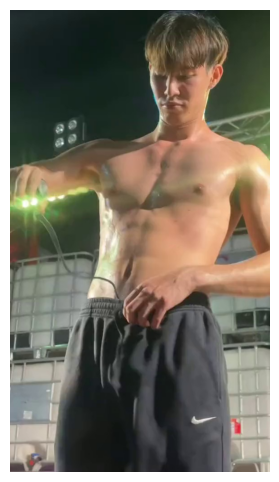

In [38]:
# Select an image path from your dataset
image_path = df["Image Path"].iloc[15]  
# Load the image
img = cv2.imread(image_path)

# Convert BGR to RGB (since OpenCV loads in BGR format)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis("off")  
plt.show()

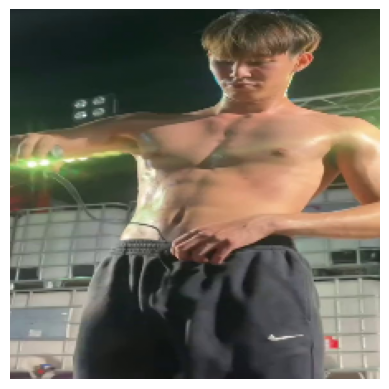

In [39]:
image_path = df["Processed Image Path"].iloc[15]
img = np.load(image_path)
plt.imshow(img)
plt.axis("off")
plt.show()


#### **`Modelling Done in Google Collab With GPUs`**